In [341]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score,r2_score
import xgboost 
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.metrics import make_scorer
r2_score = make_scorer(r2_score)

# In this note book the following steps are taken:
1. Find the best hyper parameters for estimator
2. Find the most important features by tunned random forest
3. Comapring r2 of the tuuned full model and model with selected features
4. Furthur step is finding tuned model with selected features and comparing the hyper parameters

In [342]:
#import data
Data=pd.read_csv("Kitchener-Transfomed-Data.csv")

In [343]:
X = Data.iloc[:,:-1]
y = Data.iloc[:,-1]

In [344]:
#split test and training set. total number of data is 330 so the test size cannot be large
np.random.seed(60)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 1000)

In [345]:
regressors = {}
regressors.update({"XGBoost": XGBRegressor(random_state=1000)})
FEATURE_IMPORTANCE = {"XGBoost"}

In [346]:
#Define range of hyperparameters for estimator
np.random.seed(60)
parameters = {}
parameters.update({"XGBoost": { 
                                    "regressor__learning_rate":[0.001,0.01,0.02,0.1,0.25,0.5,1],
                                    "regressor__gamma":[0.001,0.01,0.02,0.1,0.25,0.5,1],
                                    "regressor__max_depth" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30],
                                    "regressor__reg_alpha":[0.001,0.01,0.02,0.1],
                                    "regressor__reg_lambda":[0.001,0.01,0.02,0.1],
                                    "regressor__min_child_weight":[0.001,0.01,0.02,0.1]}
})

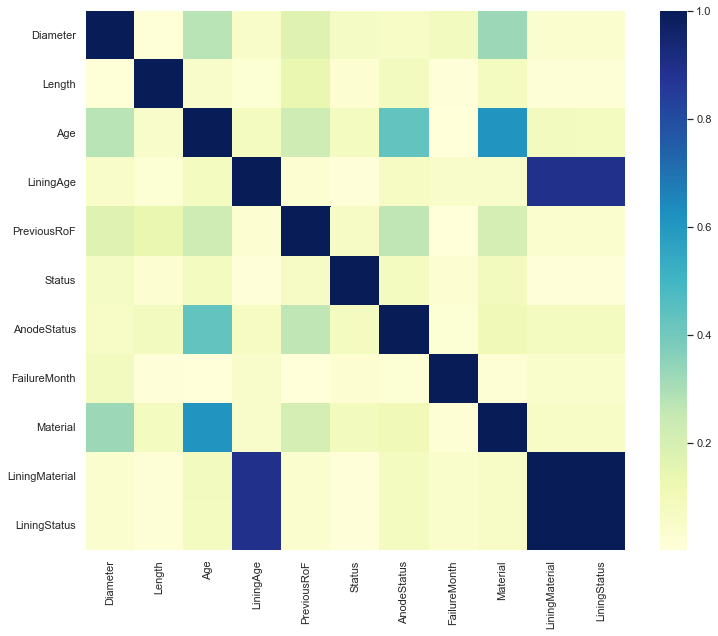

In [347]:
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

In [348]:
X_train

,Diameter,Length,Age,LiningAge,PreviousRoF,Status,AnodeStatus,FailureMonth,Material
490,150,1.344840,64,0,0.000000,1.010834,2.072589,4.777549,3.388623
69,450,1.493369,51,0,0.013130,1.010834,2.072589,7.053187,-0.583728
497,450,0.513211,33,0,0.000000,1.010834,2.072589,6.884387,3.388623
772,150,2.445706,39,0,0.020968,1.010834,2.072589,5.675163,3.388623
913,150,0.990417,43,0,0.023481,1.010834,2.072589,6.884387,3.388623
...,...,...,...,...,...,...,...,...,...
251,150,4.220677,34,0,0.000000,1.010834,2.072589,5.675163,2.891550
704,200,0.581399,46,0,0.074782,1.010834,2.072589,6.884387,3.388623
71,300,2.841397,46,0,0.000000,1.010834,1.072589,7.385145,3.388623
599,150,0.510382,52,0,0.037679,1.010834,1.072589,4.777549,3.388623


In [349]:
FEATURE_IMPORTANCE = {"XGBoost"}
selected_regressor = "XGBoost"
regressor = regressors[selected_regressor]

In [350]:
results = {}
for regressor_label, regressor in regressors.items():
    # Print message to user
    print(f"Now tuning {regressor_label}.")

Now tuning XGBoost.


In [351]:
scaler = StandardScaler()
steps = [("scaler", scaler), ("regressor", regressor)]
pipeline = Pipeline(steps = steps)

In [352]:
#Define parameters that we want to use in gridsearch cv
param_grid = parameters[selected_regressor]

In [353]:
# Initialize GridSearch object for estimator
gscv = RandomizedSearchCV(pipeline, param_grid, cv = 3,  n_jobs= -1, verbose = 1, scoring = r2_score, n_iter=10)

In [354]:
# Fit gscv (Tunes estimator)
print(f"Now tuning {selected_regressor}. Go grab a beer or something.")
gscv.fit(X_train, np.ravel(y_train))  

Now tuning XGBoost. Go grab a beer or something.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           enable_categorical=False,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                               

In [355]:
#Getting the best hyperparameters
best_params = gscv.best_params_
best_params

{'regressor__reg_lambda': 0.01,
 'regressor__reg_alpha': 0.1,
 'regressor__min_child_weight': 0.001,
 'regressor__max_depth': 11,
 'regressor__learning_rate': 0.01,
 'regressor__gamma': 0.001}

In [356]:
#Getting the best score of model
best_score = gscv.best_score_
best_score

0.2856359176714852

In [357]:
#Check overfitting of the estimator
from sklearn.model_selection import cross_val_score
mod = XGBRegressor(gamma= 0.001,
                   learning_rate= 0.01,
                   max_depth=11, 
                   min_child_weight= 0.001, 
                   reg_alpha=0.1,
                   reg_lambda = 0.01  ,random_state=10000)

scores_test = cross_val_score(mod, X_test, y_test, scoring='r2', cv=5)

scores_test

array([0.76141036, 0.6956933 , 0.71727604, 0.40237198, 0.82235861])

In [358]:
tuned_params = {item[11:]: best_params[item] for item in best_params}
regressor.set_params(**tuned_params)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=0.001, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=11,
             min_child_weight=0.001, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1000, reg_alpha=0.1, reg_lambda=0.01,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [359]:
#Find r2 of the model with all features (Model is tuned for all features)
results={}
model=regressor.set_params(gamma= 0.01,
                   learning_rate= 0.01,
                   max_depth=20, 
                   min_child_weight= 0.001, 
                   reg_alpha=0.1,
                   reg_lambda = 0.01  ,random_state=10000)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
R2 = metrics.r2_score(y_test, y_pred)
results = {"classifier": model,
              "Best Parameters": best_params,
              "Training r2": best_score*100,
              "Test r2": R2*100}
results

{'classifier': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.01, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=20, min_child_weight=0.001, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=10000,
              reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'Best Parameters': {'regressor__reg_lambda': 0.01,
  'regressor__reg_alpha': 0.1,
  'regressor__min_child_weight': 0.001,
  'regressor__max_depth': 11,
  'regressor__learning_rate': 0.01,
  'regressor__gamma': 0.001},
 'Training r2': 28.563591767148523,
 'Test r2': 82.88912291880641}

In [360]:
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [361]:
steps = [("scaler", scaler), ("regressor", regressor)]
pipe = PipelineRFE(steps = steps)
np.random.seed(60)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 5, step = 1, verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator wi

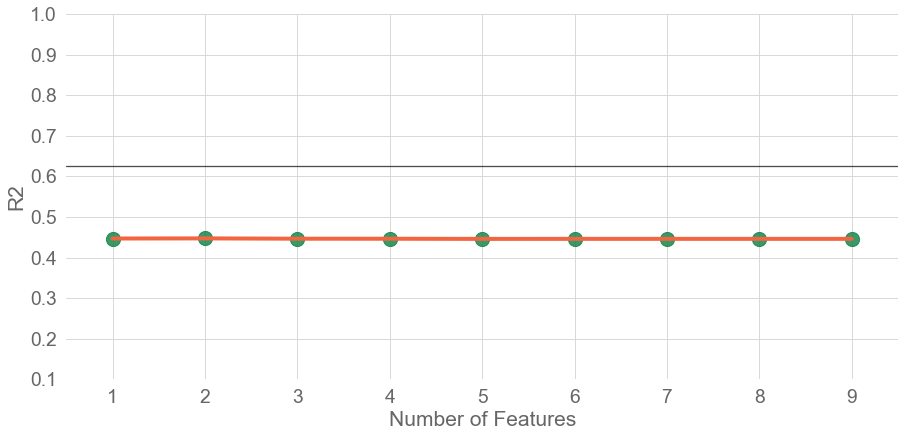

In [362]:
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "R2": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "R2", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["R2"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.1, 1)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

In [363]:
#Define new training and test set based based on selected features by RFECV
X_train_rfecv = X_train[selected_features]
X_test_rfecv= X_test[selected_features]

In [364]:
np.random.seed(60)
regressor.fit(X_train_rfecv, np.ravel(y_train))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=20, min_child_weight=0.001, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=10000,
             reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [365]:
#Finding important features
np.random.seed(60)
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = regressor.feature_importances_
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)
feature_importance

,Feature Label,Feature Importance
0,Length,0.997657
1,AnodeStatus,0.002343


In [366]:
# Initialize GridSearch object for model with selected features
np.random.seed(60)
gscv = RandomizedSearchCV(pipeline, param_grid, cv = 3,  n_jobs= -1, verbose = 1, scoring = r2_score, n_iter=20)

In [367]:
#Tuning random forest classifier with selected features 
np.random.seed(60)
gscv.fit(X_train_rfecv,y_train) 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.1s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           colsample_bylevel=1,
                                                           colsample_bynode=1,
                                                           colsample_bytree=1,
                                                           enable_categorical=False,
                                                           gamma=0.01,
                                                           gpu_id=-1,
                                                           importance_type=None,
                                                           interaction_constraints='',
                                                         

In [368]:
#Getting the best parameters of model with selected features
best_params = gscv.best_params_
best_params

{'regressor__reg_lambda': 0.02,
 'regressor__reg_alpha': 0.001,
 'regressor__min_child_weight': 0.02,
 'regressor__max_depth': 15,
 'regressor__learning_rate': 0.01,
 'regressor__gamma': 1}

In [369]:
#Getting the score of model with selected features
best_score = gscv.best_score_
best_score

0.29284567695447117

In [370]:
#Check overfitting of the  tuned model with selected features 
from sklearn.model_selection import cross_val_score
mod = XGBRegressor(gamma= 1,
                   learning_rate= 0.01,
                   max_depth=15, 
                   min_child_weight= 0.02, 
                   reg_alpha=0.001, 
                   reg_lambda = 0.02   ,random_state=10000)

scores_test = cross_val_score(mod, X_test_rfecv, y_test, scoring='r2', cv=5)

scores_test

array([0.76752777, 0.72820395, 0.69752168, 0.38594156, 0.83598495])

In [371]:
results={}
model=regressor.set_params(gamma= 1,
                   learning_rate= 0.01,
                   max_depth=15, 
                   min_child_weight= 0.02, 
                   reg_alpha=0.001, 
                   reg_lambda = 0.02   ,random_state=10000)
model.fit(X_train_rfecv,y_train)
y_pred = model.predict(X_test_rfecv)
R2 = metrics.r2_score(y_test, y_pred)
results = {"classifier": model,
              "Best Parameters": best_params,
              "Training r2": best_score*100,
              "Test r2": R2*100}
results

{'classifier': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=15, min_child_weight=0.02, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=10000,
              reg_alpha=0.001, reg_lambda=0.02, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'Best Parameters': {'regressor__reg_lambda': 0.02,
  'regressor__reg_alpha': 0.001,
  'regressor__min_child_weight': 0.02,
  'regressor__max_depth': 15,
  'regressor__learning_rate': 0.01,
  'regressor__gamma': 1},
 'Training r2': 29.284567695447116,
 'Test r2': 83.21707485936076}